In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyearth import Earth
import scipy
import sklearn
from sklearn import metrics
from scipy.stats import ttest_ind
import subprocess, os
from sklearn.cluster import KMeans
from nibabel.affines import apply_affine
import numpy.linalg as npl

In [8]:
niftifile = "WMdistance_maxdistance10_mask.nii"
subprocess.check_output("fslmaths "+niftifile+" -mul 1 imageWMdis_notbinarized.nii", shell=True);
subprocess.check_output("gzip -f -d imageWMdis_notbinarized.nii.gz", shell=True);
subprocess.check_output("flirt -in imageWMdis_notbinarized.nii -ref imageWMdis_notbinarized.nii -out imageWMdis_notbinarized_0point5mm.nii -applyisoxfm 0.5 -noresampblur", shell=True);
subprocess.check_output("gzip -f -d imageWMdis_notbinarized_0point5mm.nii.gz", shell=True);
subprocess.check_output("fslroi imageWMdis_notbinarized_0point5mm.nii imageWMdis_notbinarized_0point5mm_resized.nii 0 364 0 436 0 364", shell=True);
subprocess.check_output("gzip -f -d imageWMdis_notbinarized_0point5mm_resized.nii.gz", shell=True);


In [5]:
#filename says 2mm, but these are actually upsampled to 0.5mm using these commands:
#niftifile = "WMdistance_maxdistance10_mask.nii"
#subprocess.check_output("fslmaths "+niftifile+" -mul 1 imageWMdis_notbinarized.nii", shell=True);
#subprocess.check_output("gzip -f -d imageWMdis_notbinarized.nii.gz", shell=True);
#subprocess.check_output("flirt -in imageWMdis_notbinarized.nii -ref imageWMdis_notbinarized.nii -out imageWMdis_notbinarized_0point5mm.nii -applyisoxfm 0.5 -noresampblur", shell=True);
#subprocess.check_output("gzip -f -d imageWMdis_notbinarized_0point5mm.nii.gz", shell=True);
#subprocess.check_output("fslroi imageWMdis_notbinarized_0point5mm.nii imageWMdis_notbinarized_0point5mm_resized.nii 0 364 0 436 0 364", shell=True);
#subprocess.check_output("gzip -f -d imageWMdis_notbinarized_0point5mm_resized.nii.gz", shell=True);
#subprocess.check_output("mri_mask imageWMdis_notbinarized_0point5mm_resized.nii cerebellum_bilateral.nii imageWMdis_notbinarized_0point5mm_resized_cerebellummasked.nii", shell=True);

g1_img = nib.load('image1_notbinarized_2mm_resized_cerebellummasked.nii')
g1_img_data = g1_img.get_fdata()

g2_img = nib.load('image2_notbinarized_2mm_resized_cerebellummasked.nii')
g2_img_data = g2_img.get_fdata()

g3_img = nib.load('image3_notbinarized_2mm_resized_cerebellummasked.nii')
g3_img_data = g3_img.get_fdata()

g1_img_data.shape


(364, 436, 364)

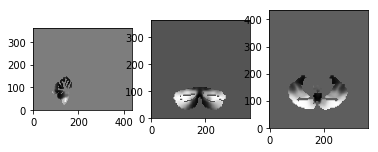

In [38]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = g1_img_data[182, :, :]
slice_1 = g1_img_data[:, 100, :]
slice_2 = g1_img_data[:, :, 80]
show_slices([slice_0, slice_1, slice_2])
plt.show()

In [46]:
g1_vox2anat_vox = npl.inv(anat_img.affine).dot(g1_img.affine)
g1_vox2anat_vox
# the affine is the same for gradient 2 and 3

array([[  1.,   0.,   0.,   0.],
       [  0.,  -1.,   0., 435.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]])

In [63]:
## this tells me the position of each coordinate in g1 to the coordinate system of the anatomical image,
# but I want to then re-arrange the order of dots in g1 so that they become the order of the anatomical
apply_affine(g1_vox2anat_vox, ([1, 1, 1], [2, 2, 3]))

array([[  1., 434.,   1.],
       [  2., 433.,   3.]])

In [84]:
# create a np array with the same shape as my g1 array
g1_registered = np.zeros((364, 436, 364))

In [119]:
# change the position of each value so that the two images become registered
for x in np.arange(g1_registered.shape[0]):
    for y in np.arange(g1_registered.shape[1]):
        for z in np.arange(g1_registered.shape[2]):
            newcoords=apply_affine(g1_vox2anat_vox, ([int(x), int(y), int(z)]))
            g1_registered[int(x), int(y), int(z)] = g1_img_data[int(newcoords[0]), int(newcoords[1]), int(newcoords[2])]

In [48]:
# the same for gradients 2 and 3:

g2_registered = np.zeros((364, 436, 364))
g3_registered = np.zeros((364, 436, 364))

for x in np.arange(g2_registered.shape[0]):
    for y in np.arange(g2_registered.shape[1]):
        for z in np.arange(g2_registered.shape[2]):
            newcoords=apply_affine(g1_vox2anat_vox, ([int(x), int(y), int(z)]))
            g2_registered[int(x), int(y), int(z)] = g2_img_data[int(newcoords[0]), int(newcoords[1]), int(newcoords[2])]

np.save('gradient2_0point5mm_RegisteredTo7Tspace', g2_registered)            
            
for x in np.arange(g3_registered.shape[0]):
    for y in np.arange(g3_registered.shape[1]):
        for z in np.arange(g3_registered.shape[2]):
            newcoords=apply_affine(g1_vox2anat_vox, ([int(x), int(y), int(z)]))
            g3_registered[int(x), int(y), int(z)] = g3_img_data[int(newcoords[0]), int(newcoords[1]), int(newcoords[2])]
            
np.save('gradient3_0point5mm_RegisteredTo7Tspace', g3_registered)

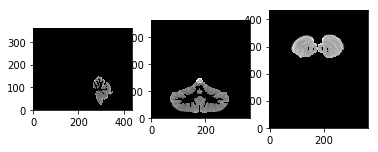

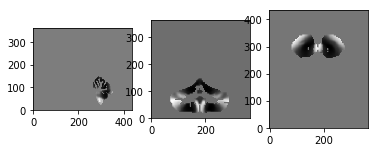

In [124]:
# now the anatomical image is aligned with the gradient 1 image
show_slices([anat_img_data[182, :, :],
             anat_img_data[:, 300, :],
             anat_img_data[:, :, 40]])

show_slices([g1_registered[182, :, :],
             g1_registered[:, 300, :],
             g1_registered[:, :, 40]])

In [135]:
np.save('gradient1_0point5mm_RegisteredTo7Tspace', g1_registered)

In [139]:
g1_registered_masked = g1_registered[anat_img_data!=0]

In [31]:
anat_img_data_masked = anat_img_data[anat_img_data>6318857]

In [32]:
np.save('7T_0point5mm_RegisteredTo7Tspace', anat_img_data_masked)

In [34]:
anat_img_data_masked.shape

(1112658,)

In [35]:
g1_registered_masked.shape

(1112658,)

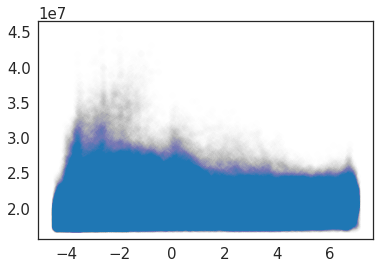

In [16]:
anat_img = nib.load('image_notbinarized_2mm_resized_cerebellummasked.nii')
anat_img_data = anat_img.get_fdata()
g1_registered = np.load('gradient1_0point5mm_RegisteredTo7Tspace.npy')
g1_registered_masked = g1_registered[anat_img_data>6318857] # exclude some aspects of the image that are outside of the cerebellum after cerebellar masking
anat_img_data_masked = np.load('7T_0point5mm_RegisteredTo7Tspace.npy')

#threshold further to 1700000:
g1_registered_masked = g1_registered_masked[anat_img_data_masked>17000000] # exclude some aspects of the image that are outside of the cerebellum after cerebellar masking
anat_img_data_masked = anat_img_data_masked[anat_img_data_masked>17000000] # exclude some aspects of the image that are outside of the cerebellum after cerebellar masking


plt.scatter(g1_registered_masked/10000, anat_img_data_masked, alpha=0.002)
plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-----------------------------------------------------------------------
iter  parent  var  knot  mse           terms  gcv        rsq    grsq   
-----------------------------------------------------------------------
0     -       -    -     56772.806789  1      56772.920  0.000  0.000  
1     0       0    -1    56769.765525  2      56770.161  0.000  0.000  
-----------------------------------------------------------------------
Stopping Condition 2: Improvement below threshold

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   2      56769.77  56770.161  0.000  0.000  
1     1   1      56772.81  56772.920  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      

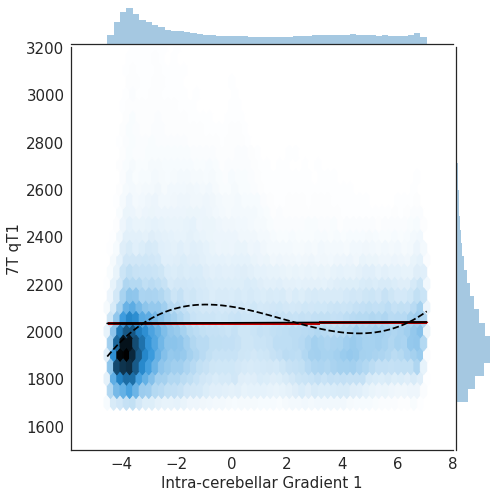

In [17]:
gradient = g1_registered_masked/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-5.8, 8], ylim=[1500, 3200],
                     space=0.1, 
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 1', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       56772.806789  1      56772.920  0.000  0.000  
1     0       0    980714  56728.418594  3      56729.096  0.001  0.001  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      56728.42  56729.096  0.001  0.001  
1     1   2      56728.89  56729.286  0.001  0.001  
2     2   1      56772.81  56772.920  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coeffic

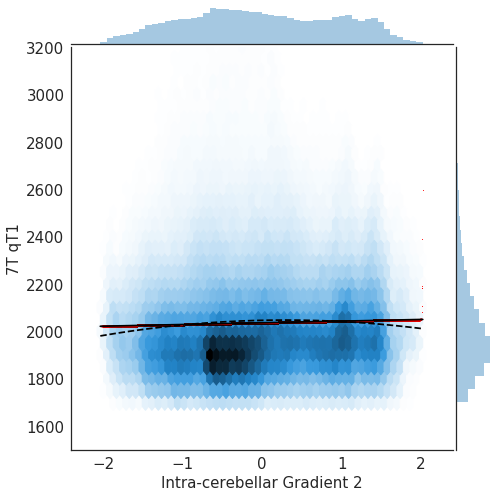

In [18]:
g2_registered = np.load('gradient2_0point5mm_RegisteredTo7Tspace.npy')
g2_registered_masked = g2_registered[anat_img_data>17000000] # exclude some aspects of the image that are outside of the cerebellum after cerebellar masking


gradient = g2_registered_masked/10000
myelin = anat_img_data_masked/10000

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-2.4, 2.4], ylim=[1500, 3200], space=0.1, 
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 2', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       56772.806789  1      56772.920  0.000  0.000  
1     0       0    123057  56689.544342  3      56690.221  0.001  0.001  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      56689.54  56690.221  0.001  0.001  
1     1   2      56690.06  56690.452  0.001  0.001  
2     2   1      56772.81  56772.920  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coeffic

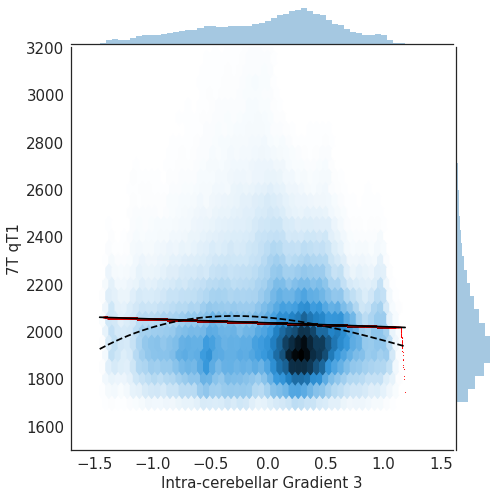

In [19]:
g3_registered = np.load('gradient3_0point5mm_RegisteredTo7Tspace.npy')
g3_registered_masked = g3_registered[anat_img_data>17000000] # exclude some aspects of the image that are outside of the cerebellum after cerebellar masking


gradient = g3_registered_masked/10000
myelin = anat_img_data_masked/10000

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-1.7, 1.6], ylim=[1500, 3200], space=0.1, 
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 3', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

In [22]:
# first register to 7T structural space
WMdis_img = nib.load('imageWMdis_notbinarized_0point5mm_resized.nii')
WMdis_img_data = WMdis_img.get_fdata()

# change the position of each value so that the two images become registered
WMdis_vox2anat_vox = npl.inv(anat_img.affine).dot(WMdis_img.affine)
WMdis_registered = np.zeros((364, 436, 364))

for x in np.arange(WMdis_registered.shape[0]):
    for y in np.arange(WMdis_registered.shape[1]):
        for z in np.arange(WMdis_registered.shape[2]):
            newcoords=apply_affine(WMdis_vox2anat_vox, ([int(x), int(y), int(z)]))
            WMdis_registered[int(x), int(y), int(z)] = WMdis_img_data[int(newcoords[0]), int(newcoords[1]), int(newcoords[2])]

np.save('WMdis_0point5mm_RegisteredTo7Tspace', WMdis_registered) 

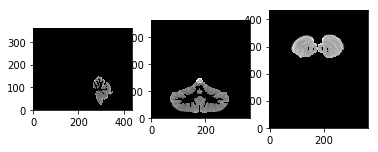

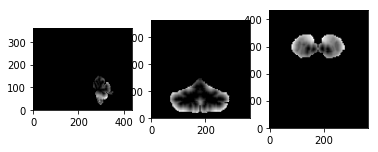

In [23]:
# now the anatomical image is aligned with the WM distance image

show_slices([anat_img_data[182, :, :],
             anat_img_data[:, 300, :],
             anat_img_data[:, :, 40]])

show_slices([WMdis_registered[182, :, :],
             WMdis_registered[:, 300, :],
             WMdis_registered[:, :, 40]])

In [20]:
WMdis_img = nib.load('imageWMdis_notbinarized_0point5mm_resized.nii').get_fdata()
np.unique(WMdis_img)

array([0.        , 0.0078125 , 0.015625  , ..., 7.61258459, 7.63616371,
       7.68191624])

In [21]:
WMdis_registered = np.load('WMdis_0point5mm_RegisteredTo7Tspace.npy')
np.unique(WMdis_registered)

array([0.        , 0.0078125 , 0.015625  , ..., 7.61258459, 7.63616371,
       7.68191624])

In [22]:
#threshold so that non-cerebellum is not included, and also threshold with 6318857 so that some aspects of the 7T file that are not cerebellum are also excluded
anat_img = nib.load('image_notbinarized_2mm_resized_cerebellummasked.nii')
anat_img_data = anat_img.get_fdata()
WMdis_registered = np.load('WMdis_0point5mm_RegisteredTo7Tspace.npy')
WMdis_registered_masked = WMdis_registered[anat_img_data>6318857]

# also need to do that with the 7T T1 file:
anat_img_data = anat_img_data[anat_img_data>6318857]

# perform an additional thresholding of 17000000 to exclude aspects that are not cerebellum:
WMdis_registered_masked = WMdis_registered_masked[anat_img_data>17000000]
anat_img_data = anat_img_data[anat_img_data>17000000]


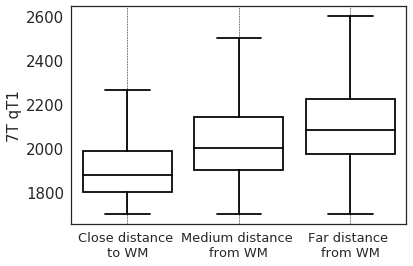

close to medium: Ttest_indResult(statistic=-91.29424659215027, pvalue=0.0)
far to medium: Ttest_indResult(statistic=154.7755578100938, pvalue=0.0)
far to close: Ttest_indResult(statistic=181.57274867857507, pvalue=0.0)


In [23]:
anat_img_data = anat_img_data.copy()/10000

datatoplot = [anat_img_data[WMdis_registered_masked<1.099], 
              anat_img_data[(WMdis_registered_masked>2.015) & (WMdis_registered_masked<3.358)], 
              anat_img_data[WMdis_registered_masked>4.443]]

labels = ['Close distance \nto WM', 'Medium distance \nfrom WM', 'Far distance \nfrom WM']
ax = sns.boxplot(data=datatoplot, orient='v',showfliers=False, color='w')
plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')

#sns.set_style('whitegrid')
ax.grid(color='k', linestyle='--', linewidth=0.5, axis='x')
ax.set_xticklabels(labels, size=13); plt.ylabel('7T qT1', size=15)
plt.savefig(os.path.abspath('./7T_distanceToWM.png'), format='png', dpi=600)
plt.show()

print('close to medium: '+str(scipy.stats.ttest_ind(anat_img_data[WMdis_registered_masked<0.501], anat_img_data[(WMdis_registered_masked>0.501) & (WMdis_registered_masked<2)], equal_var=False)))
print('far to medium: '+str(scipy.stats.ttest_ind(anat_img_data[WMdis_registered_masked>3.26], anat_img_data[(WMdis_registered_masked>0.501) & (WMdis_registered_masked<2)], equal_var=False)))
print('far to close: '+str(scipy.stats.ttest_ind(anat_img_data[WMdis_registered_masked>3.26], anat_img_data[(WMdis_registered_masked<0.501)], equal_var=False)))

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       56772.806789  1      56772.920  0.000  0.000  
1     0       0    789727  53909.033766  3      53909.678  0.050  0.050  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      53909.03  53909.678  0.050  0.050  
1     1   2      54543.14  54543.519  0.039  0.039  
2     2   1      56772.81  56772.920  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coeffic

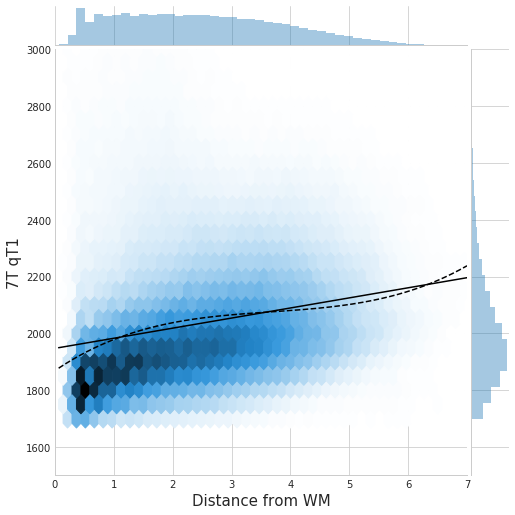

Linear equation:   
35.54 x + 1947
Pearson r linear equation:  0.2082499287994686 , r^2:  0.043368032844983744
Pearson p linear equation:  0.0
Spearman r linear equation:  0.3367084365908872
Spearman p linear equation:  0.0
Quadratic equation:
       3         2
3.138 x - 34.57 x + 141 x + 1869
r^2 for quadratic equation:  0.048977757837613156


In [38]:
#plot myelin against functional gradient
fig = (sns.jointplot(WMdis_registered_masked, anat_img_data, kind='hex', size=7, ratio=10,
                     xlim = [0, 7], ylim = [1500, 3000],
                     space=0.1, stat_func=None).set_axis_labels('Distance from WM', '7T qT1', fontsize=15))

#CALCULATE REGRESSIONS:
x= WMdis_registered_masked
xp = np.linspace(np.min(x), np.max(x), len(x)) 

y= anat_img_data
z3 = np.polyfit(x, y, 3) #cubic regression
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1) #linear regression
p1 = np.poly1d(z1)

#use py-earth to calculate splines:
Xearth = WMdis_registered_masked
yearth = anat_img_data
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)

plt.show()

pear_r = scipy.stats.pearsonr(WMdis_registered_masked, anat_img_data)
spear_r = scipy.stats.spearmanr(WMdis_registered_masked, anat_img_data)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Quadratic equation:')
print((np.poly1d(p3)))
print('r^2 for quadratic equation: ', sklearn.metrics.r2_score(y, p3(x)))


/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
------------------------------------------------------------------------
iter  parent  var  knot   mse           terms  gcv        rsq    grsq   
------------------------------------------------------------------------
0     -       -    -      37899.802149  1      37900.549  0.000  0.000  
1     0       0    52335  35563.922327  3      35568.129  0.062  0.062  
------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      35563.92  35568.129  0.062  0.062  
1     1   2      35696.86  35699.319  0.058  0.058  
2     2   1      37899.80  37900.549  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  

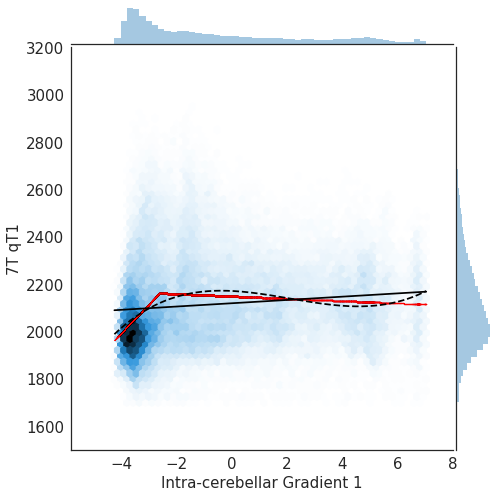

In [7]:
# gradient 1, layer far from WM

gradient = g1_registered_masked[WMdis_registered_masked>4.443]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[WMdis_registered_masked>4.443]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-5.8, 8], ylim=[1500, 3200],
                     space=0.1, 
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 1', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_Far_gradient1.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       61998.639142  1      61999.290  0.000  0.000  
1     0       0    151196  59449.197381  3      59452.942  0.041  0.041  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
------------------------------------------------------
iter  bf  terms  mse       gcv        rsq     grsq    
------------------------------------------------------
0     -   3      59449.20  59452.942  0.041   0.041   
1     2   2      61268.35  61270.596  0.012   0.012   
2     1   1      61998.64  61999.290  -0.000  -0.000  
------------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  P

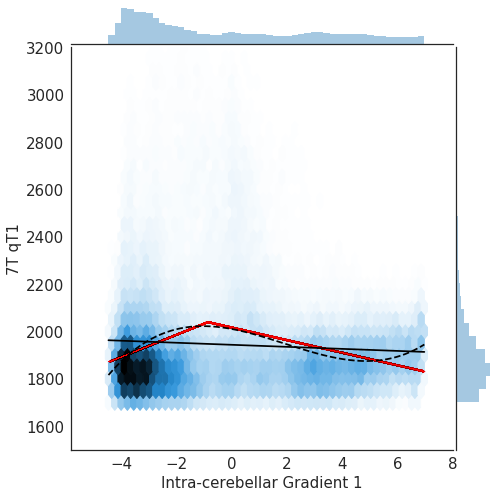

In [8]:
# gradient 1, layer close from WM

gradient = g1_registered_masked[WMdis_registered_masked<1.099]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[WMdis_registered_masked<1.099]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-5.8, 8], ylim=[1500, 3200],
                     space=0.1, 
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 1', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_close_gradient1.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       48444.726363  1      48445.041  0.000  0.000  
1     0       0    282803  47209.977311  3      47211.819  0.025  0.025  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      47209.98  47211.819  0.025  0.025  
1     1   2      47883.64  47884.732  0.012  0.012  
2     2   1      48444.73  48445.041  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coeffic

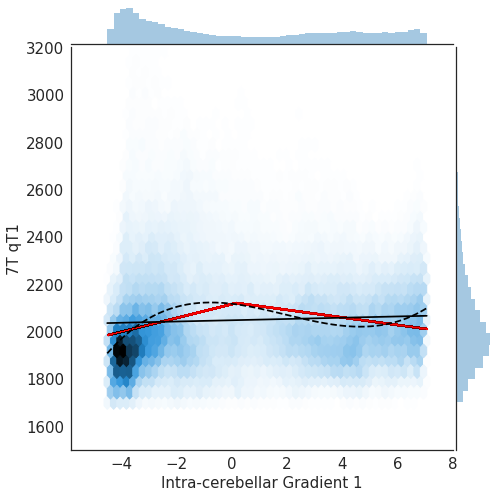

In [9]:
# gradient 1, layer medium from WM

gradient = g1_registered_masked[(WMdis_registered_masked>2.015) & (WMdis_registered_masked<3.358)]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[(WMdis_registered_masked>2.015) & (WMdis_registered_masked<3.358)]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-5.8, 8], ylim=[1500, 3200],
                     space=0.1, 
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 1', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_medium_gradient1.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
------------------------------------------------------------------------
iter  parent  var  knot   mse           terms  gcv        rsq    grsq   
------------------------------------------------------------------------
0     -       -    -      37899.802149  1      37900.549  0.000  0.000  
1     0       0    66589  37831.084687  3      37835.559  0.002  0.002  
------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      37831.08  37835.559  0.002  0.002  
1     2   2      37848.43  37851.043  0.001  0.001  
2     1   1      37899.80  37900.549  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  

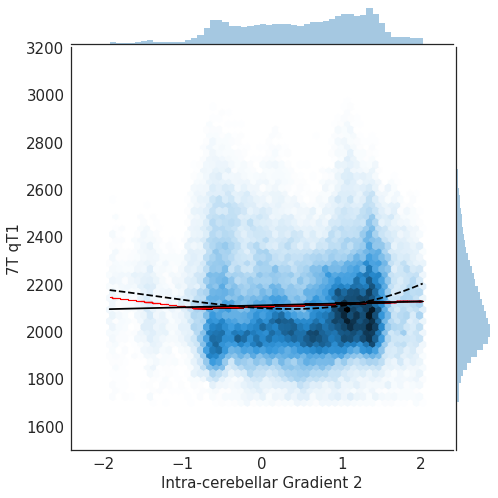

In [25]:
# gradient 2, layer far from WM

gradient = g2_registered_masked[WMdis_registered_masked>4.443]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[WMdis_registered_masked>4.443]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-2.4, 2.4], ylim=[1500, 3200], space=0.1,
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 2', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_Far_gradient2.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       61998.639142  1      61999.290  0.000  0.000  
1     0       0    183969  61859.876340  3      61863.773  0.002  0.002  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
------------------------------------------------------
iter  bf  terms  mse       gcv        rsq     grsq    
------------------------------------------------------
0     -   3      61859.88  61863.773  0.002   0.002   
1     1   2      61863.17  61865.447  0.002   0.002   
2     2   1      61998.64  61999.290  -0.000  -0.000  
------------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  P

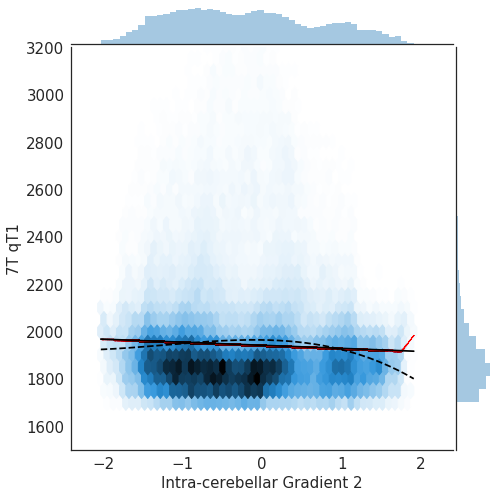

In [26]:
# gradient 2, layer close from WM

gradient = g2_registered_masked[WMdis_registered_masked<1.099]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[WMdis_registered_masked<1.099]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-2.4, 2.4], ylim=[1500, 3200], space=0.1,
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 2', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_close_gradient2.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       48444.726363  1      48445.041  0.000  0.000  
1     0       0    295919  48437.090830  3      48438.980  0.000  0.000  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      48437.09  48438.980  0.000  0.000  
1     2   2      48437.11  48438.216  0.000  0.000  
2     1   1      48444.73  48445.041  0.000  0.000  
----------------------------------------------------
Selected iteration: 1

Earth Model
-------------------------------------
Basis Function  Pruned  Coeffic

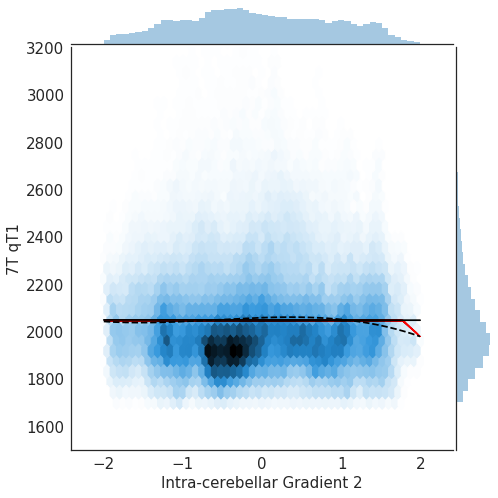

In [27]:
# gradient 2, layer medium from WM

gradient = g2_registered_masked[(WMdis_registered_masked>2.015) & (WMdis_registered_masked<3.358)]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[(WMdis_registered_masked>2.015) & (WMdis_registered_masked<3.358)]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-2.4, 2.4], ylim=[1500, 3200], space=0.1,
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 2', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_medium_gradient2.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
------------------------------------------------------------------------
iter  parent  var  knot   mse           terms  gcv        rsq    grsq   
------------------------------------------------------------------------
0     -       -    -      37899.802149  1      37900.549  0.000  0.000  
1     0       0    49950  36037.429879  3      36041.692  0.049  0.049  
------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      36037.43  36041.692  0.049  0.049  
1     2   2      36652.15  36654.681  0.033  0.033  
2     1   1      37899.80  37900.549  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  

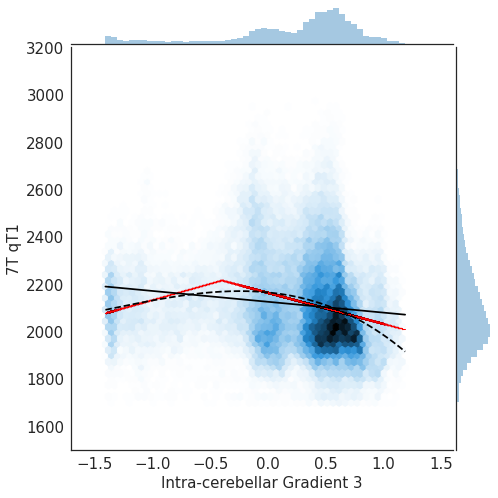

In [28]:
# gradient 3, layer far from WM

gradient = g3_registered_masked[WMdis_registered_masked>4.443]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[WMdis_registered_masked>4.443]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-1.7, 1.6], ylim=[1500, 3200], space=0.1,
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 3', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_Far_gradient3.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
-------------------------------------------------------------------------
iter  parent  var  knot    mse           terms  gcv        rsq    grsq   
-------------------------------------------------------------------------
0     -       -    -       61998.639142  1      61999.290  0.000  0.000  
1     0       0    187628  61507.580807  3      61511.455  0.008  0.008  
-------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
------------------------------------------------------
iter  bf  terms  mse       gcv        rsq     grsq    
------------------------------------------------------
0     -   3      61507.58  61511.455  0.008   0.008   
1     2   2      61628.51  61630.772  0.006   0.006   
2     1   1      61998.64  61999.290  -0.000  -0.000  
------------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  P

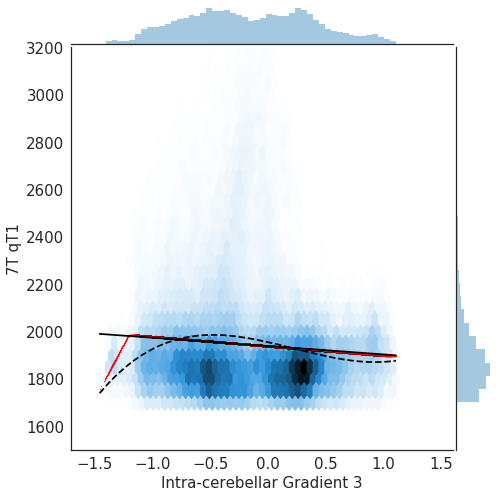

In [29]:
# gradient 3, layer close from WM

gradient = g3_registered_masked[WMdis_registered_masked<1.099]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[WMdis_registered_masked<1.099]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-1.7, 1.6], ylim=[1500, 3200], space=0.1,
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 3', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_close_gradient3.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this wa

Forward Pass
------------------------------------------------------------------------
iter  parent  var  knot   mse           terms  gcv        rsq    grsq   
------------------------------------------------------------------------
0     -       -    -      48444.726363  1      48445.041  0.000  0.000  
1     0       0    54975  48110.960581  3      48112.837  0.007  0.007  
------------------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
----------------------------------------------------
iter  bf  terms  mse       gcv        rsq    grsq   
----------------------------------------------------
0     -   3      48110.96  48112.837  0.007  0.007  
1     1   2      48124.59  48125.682  0.007  0.007  
2     2   1      48444.73  48445.041  0.000  0.000  
----------------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  

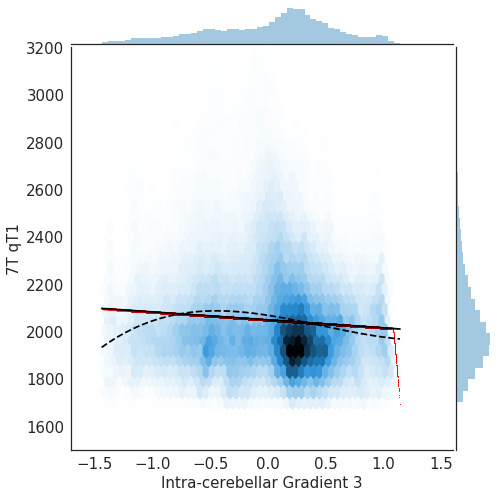

In [30]:
# gradient 3, layer medium from WM

gradient = g3_registered_masked[(WMdis_registered_masked>2.015) & (WMdis_registered_masked<3.358)]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
myelin = anat_img_data_masked[(WMdis_registered_masked>2.015) & (WMdis_registered_masked<3.358)]/10000 # this is because I multiplied by 10000 when using nonbinary littlebrain code
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-1.7, 1.6], ylim=[1500, 3200], space=0.1,
                     stat_func=None).set_axis_labels('Intra-cerebellar Gradient 3', '7T qT1', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_layers_7T_medium_gradient3.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()